## Chapter 05. 회귀
### 06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

규제 선형 모델의 개요

* 이전까지 선형 모델의 비용 함수는 RSS를 최소화하는, 즉 실제 값과 예측값의 차이를 최소화하는 것만 고려
* 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉽슴

* 최적 모델을 위한 Cost 함수 구성요소 = 학습 데이터 잔차 오류 최소화 + 회귀계수 크기 제어
    
    * 비용 함수 목표 = Min(RSS(W) + alpha * ||W||22)
    * alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있음
    

* 규제(Regularization): 비용 함수에 alpha값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합 개선하는 방식

    * 릿지 회귀: L2 규제. W의 제곱에 대해 페널티를 부여하는 방식.
    * 라쏘 회귀: L1 규제. W의 절댓값에 대해 페널티를 부여.

In [4]:
from sklearn.linear_model import LinearRegression

LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

LinearRegression(n_jobs=1)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 df 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DF에 추가함.
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


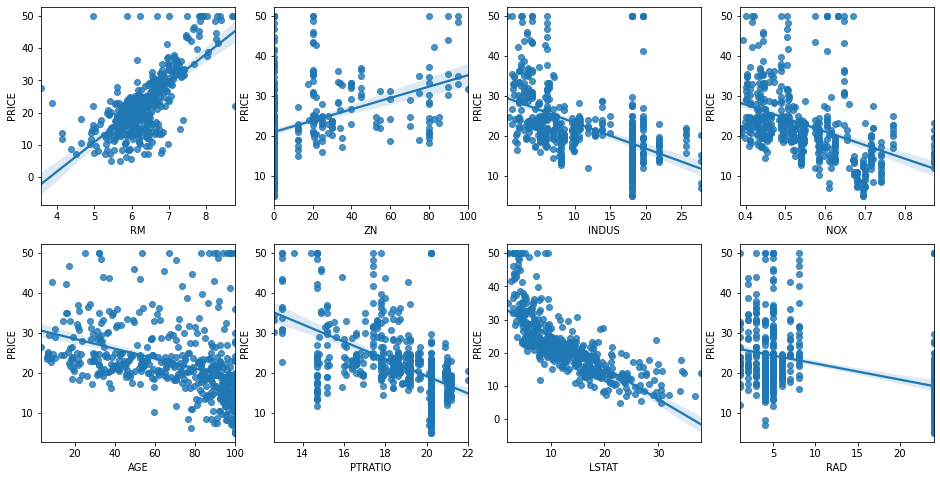

In [6]:
#2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i % 4
    #시본의 regplot을 이용해 산점도와 선형 회귀 직선 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score : 0.757


In [8]:
#LinearRegression으로 생성한 주택가격 모델의 intercept와 coefficients(회귀계수)값을 보겠습니다
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.9955951721646
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [9]:
#피처별 회귀 값으로 다시 매핑하고 높은 순으로 출력
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### 릿지 회귀
* 사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현
* 주요 생성 파라미터는 alpha, 이는 릿지 회귀의 alpha L2 규제 계수에 해당

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


릿지의 5개 폴드 세트의 평균 RMSE가 5.524로 규제가 없는 LinearRegression의 RMSE 평균인 5.836보다 더 뛰어난 예측 성능을 보여줌

In [18]:
#릿지의 apha 값을 0, 0.1, 1, 10, 100 파라미터의 값을 정의

#릿지에 사용될 alpha 파라미터 값을 정의
alphas = [0, 0.1, 1, 10, 100]

#alphas list 값을 반복하면서 alpah에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    #cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788
alpha 1 일 때 5 folds의 평균 RMSE : 5.653
alpha 10 일 때 5 folds의 평균 RMSE : 5.518
alpha 100 일 때 5 folds의 평균 RMSE : 5.330


alpha가 100일 때 평균 RMSE가 5.5332로 가장 좋음

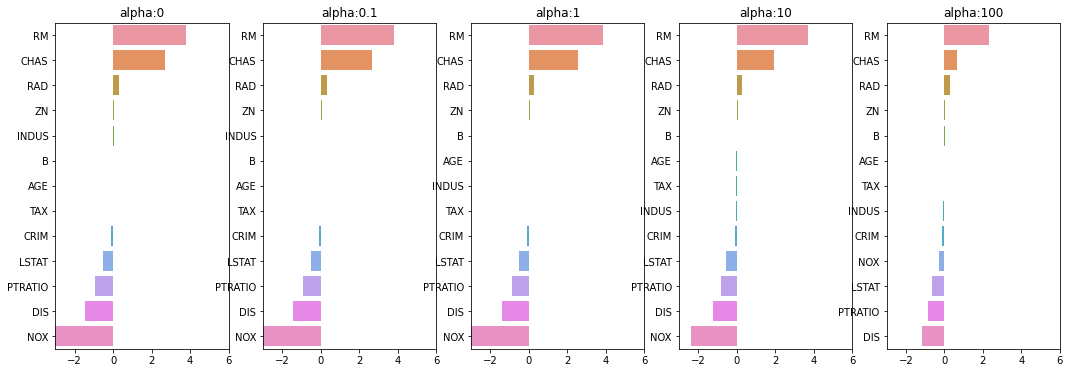

In [28]:
import matplotlib.pyplot as plt
#alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
#각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계쑤 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DF의 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    #막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
#for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DF으로 표시
plt.show()

* alpha값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐
* 특히 NOX 피처의 경우 alpha 값을 계속 증가시킴에 따라 회귀 계수가 크게 작아지고 있음

In [31]:
#DF에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수값을 구해봄

ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


* alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음
* 하지만 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않음

### 라쏘 회귀

* W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것
* L2 구제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
* 이러한 측면에서 L1 규제는 적절한 피처만 휘귀에 포함시키는 피처 선택의 특징을 가지고 있음


* 사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현. 
* 주요 생성 파라미터는 alpha, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당됨


* 라쏘의 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력

In [35]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DF으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('#######', model_name, '#######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계쑤 추출
        model.fit(X_data, y_target)
        #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DF의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff
    return coeff_df
#end of get_linear_regre_eval

In [36]:
#함수를 생성했으면 이를 이용해 alpha값의 변화에 따른 RMSE와 그때의 회귀계수들을 출력

#라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_lienar_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


alpha가 0.07일 때 가장 좋은 평균 RMSE를 보여줌.

앞의 릿지 평균 5.524보다는 약간 떨어지는 수치지만, LinearRegression 평균인 5.836보다는 향상됨

In [37]:
#alpha값에 따른 피처별 회귀 계수
#반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DF 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


* alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있음
* NOX 속성은 alpha가 0.07일 때부터 회귀계수가 0이며, alpha를 증가시키면서 INDUS, CHAS와 같은 속성의 회귀 계수가 0으로 바뀜
* 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

### 엘라스틱넷 회귀
L2 규제와 L1 규제를 결합환 회귀

* 비용 모함수 목표는 RSS(w) + alpha2 * ||W||22 + alpha1 * ||W||1 식을 최소화하는 W를 찾는 것
* 라쏘 회귀가 서로 상관관계까 높은 피처들의 경우 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함
* 특히 이러한 성향으로 인해 alpha값에 따라 회귀 꼐수의 값이 급격히 변동할 수 있음
* 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가
* 단점: 수행시간이 상대적으로 오래 걸림
    
    
* 사이킷런은 ElasticNet 클래스를 통해서 구현함
* 주요 생성 파라미터는 alpha와 l1_ratio. alpah는 Ridge와 Lasso 클래스의 alpha값과는 다름.
* 엘라스틱넷의 규제는 a*L1 + b*L2로 정의될 수 있으며, 이 때 a는 L1 규제의 alpha값, b는 L2 규제의 alpha값임
* 따라서 Elastic 클래스의 alpha 파라미터 값은 a+bdla
* l1_ratio 파라미터 값은 a/a+b
* l1_ratio가 0이면 a가 0이므로 L2 규제와 동일하고 l1_ratio가 1이면 b가 0이므로 L1 규제와 동일함

* ElasticNet 클래스를 이용해 엘라스틱넷 alpha값을 변화시키면서 RMSE와 각 피처의 회귀 계수 출력해봄
* ElasticNet 객체를 생성할 때 alpha값의 변화만을 살펴보기 위해 l1_ratio=0.7로 고정하였음

In [39]:
#엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
#l1_ratio는 0.7로 고침
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [40]:
#반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DF 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha가 0.5일 때 RMSE가 5.468로 가장 좋은 예측 성능을 보이고 있음. alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있음

* 지금까지 규제 선형 회귀의 가장 대표적인 릿지, 라쏘, 엘라스틱넷 회귀를 살펴봄. 
* 이들 중 어떤 것이 가장 좋은지는 상황에 따라 다름. 각각의 알고리즘에서 하이퍼 파라미터를 변경해가면서 최적의 예측 성능을 찾아내야 함.
* 하지만 선형회귀의 경우 최적의 하이퍼 파라미터를 찾아내는 것 못지않게 먼저 데이터 분포도의 정규화와 인코딩 방법이 매우 중요.

### 선형 회귀 모델을 위한 데이터 변환

* 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형함수를 찾아내 결과값을 예측함
* 또한 선형 회귀 모델은 <b>피처값과 타깃값의 분포가 정규 분포</b> 형태를 매우 선호
* 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 <b>왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠</b> 가능성이 높음
* 피처값 역시 결정값보다는 덜하지만 왜독된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있음


* 따라서 <b>모델 적용 전에 데이터에 대한 스케일링/정규화 작업을 수행</b>하는 것이 일반적임
* 하지만 이러한 스케일링/정규화 작업을 선행한다고 해서 무조건 예측 성능이 향상되는 것은 아님.
* 일반적으로 중요 피처들이나 타깃값이 분포도가 심하게 왜곡됐을 경우에 이러한 변환 작업을 수행함


* <b>사이킷런을 이용해 피처 데이터 세트에 적용하는 변환 작업</b>

1. StandardScaler 클래스를 이용해 평균 0, 분산 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화 수행
2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환. 1번으로 예측 성능에 향상이 없을 경우 이와 같은 방법을 적용
3. 원래 값에 log를 적용하는 Log Transformation으로 정규분포에 가까운 형태로 값이 분포되게 함. 1번은 예측 성능 향상 크게 기대하기 어렵고 2번은 피처 개수가 많으면 과적합 일어날 수 있음

* 타깃값의 경우 일반적으로 로그 변환

In [48]:
#보스턴 주택가격 피처 데이터 세트에 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그 변환을 차례로 적용한 후에 RMSE로 각 경우별 예측 성능을 측정
#method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
#p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음.

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
        
    return scaled_data

* Ridge 클래스의 alpha값을 변화시키면서 피처 데이터 세트를 여러 가지 방법으로 변환한 데이터 세트를 입력 받을 경우에 RMSE값이 어떻게 변하는지 살펴봄
* 피처 데이터의 변환 방법은 모두 5가지

1. (None, None) 아무런 변환을 하지 않은 원본 데이터
2. ('Standard', None) 표준 정규 분포
3. ('Standard', 2) 표준 정규 분포를 다시 2차 다항식 변환
4. ('MixMax', None) 최솟값/최댓값 정규화
5. ('MinMax', 2) 최솟값.최댓값 정규화를 다시 2차 다항식 변환
6. ('Log', None) 로그 변환

In [51]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
    
#Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

#5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
#최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그 변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
              ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

결과: 
* 표준 정규 분포와 최솟값/최댓값 정규화로 피처 데이터 세트를 변경해도 성능상의 개선은 없음
* 표준 정규 분포로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=100에서 4.634로 성능이 개선됐음
* 최솟값/최댓값 정규화로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=1에서 4.323으로 성능이 개선됨
   
    
* 하지만 다항식 변환은 피처의 개수가 많을 경우 적용 힘듦
* 데이터 건수가 ㅁ낳아지면 계싼에 많은 시간이 소모되어 적용에 한계가 있음
  
    
* 반면 로그 변환을 보면 alpha가 0.1, 1, 10인 경우 모두 좋은 성능 향상이 있음을 알 수 있음
    
    
일반적으로 선형 회귀 적용하려는 데이터값의 분포가 심하게 왜곡 -> 로그 변환을 적용

## 07 로지스틱 회귀
* 선형 회귀 방식을 분류에 적용한 알고리즘. 즉, 로지스틱 회귀는 분류에 사용됨
* 로지스틱 회귀 역시 선형 회귀 계열. 회귀의 선형 여부는 독립변수가 아닌 weight 변수가 선형인지 아닌지를 따름
* 로지스틱 회귀가 선형회귀와 다른 점: 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아닌 시그모이드 함수 최적선을 찾고 함수의 반환값을 확률로 간주해 확률에 따라 분류를 결정


* y = 1/1+e^(-x)로 표현
    * x값이 아무리 달라져도 y값은 항상 0과 1 사이 값을 반환
    * x값이 커지면 1에 근사하며 x값이 작아지면 0에 근사

    
* 회귀를 분류 문제에 적용 ex. 종양의 크기에 따라 악성 종양인지 그렇지 않은지 예측
* 로지스틱 회귀는 선형 회귀 방식을 기반으로 하되 시그모이드 함수를 이용해 분류를 수행하는 회귀

In [52]:
#위스콘신 유방암 데이터 세트를 이용해 로지스틱 회귀로 암 여부 판단
import pandas as pd
import matplotlib as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [53]:
#학습셋 나눈 뒤 로지스틱 회귀로 분류 수행
#선형 회귀 계열의 로지스틱 회귀는 데이터의 정규 분포도에 따라 예측 성능 영향 받을 수 있어 데이터에 먼저 정규 분포 형태의 표준 스케일링 적용 뒤 테스트셋 분리

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [55]:
#로지스틱 회귀를 이용해 학습 및 예측 수행하고 정확도와 ROC-AUC 값을 구해봄

from sklearn.metrics import accuracy_score, roc_auc_score

#로지스틱 회귀를 이용해 학습 및 예측 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print('accuracy: {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


In [58]:
#사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터로 penalty와 C가 있음
#penalty는 규제의 유형을 설정
#C는 규제 강도가 큼

#GridSearchCV를 이용해 위스콘신 데이터 세트에서 이 하이퍼 파라미터를 최적화

from sklearn.model_selection import GridSearchCV

params = { 'penalty': ['l2', 'l1'], 'C': [0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-tes

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-tes

## 08 회귀 트리

* 머신러닝 기반의 회귀는 회귀 계수를 기반으로 하는 최적 회귀 함수를 도출하는 것이 주요 목표
* 회귀 함수 기반이 아닌 결정 트리와 같은 트리 기반 회귀 방식 소개


* 트리 기반의 회귀는 회귀 트리를 이용하는 것
* 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측
* 분류 트리와 크게 다르지 않지만 리프 노드에서 예측 결정값을 만드는 과정에 차이가 있음
* 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산


* 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 모든 트리 기반의 알괴즘은 분류 뿐만 아니라 회귀도 가능
* 사이킷런에서는 결정 트리, 랜덤 포레스트, GBM에서 Estimator 클래스 제공
* XGBoost, LightGBM도 사이킷런 래퍼 클레스 통해 제공

In [13]:
#사이킷런의 랜덤 포레스트 회귀 트리인 RandomForestRegressor를 이용해 앞의 선형 회귀에서 다룬 보스턴 주택 가격 예측 수행
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

#보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores :', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores : [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [6]:
#랜덤 포레스트 뿐만 아니라 결정 트리, GBM, XGBoost, LightGBM의 Regressor를 모두 이용해 보스턴 주택 가격 예측 수행
# get_model_cv_prediction()은 입력 모델과 데이터 세트를 입력 받아 교차 검증으로 평균 RMSE를 계산해주는 함수
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#####', model.__class__.__name__, '#####')
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [7]:
#다양한 유형의 회귀 트리를 생성하고, 이를 이용해 보스턴 주택 가격을 예측
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

#트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE : 5.978
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE : 4.423
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE : 4.269
[19:38:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
##### XGBRegressor #####
5 교차 검증의 평균 RMSE : 4.089
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE : 4.646


<AxesSubplot:>

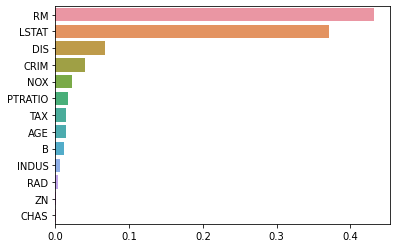

In [9]:
#회귀 트리 Regressor 클래스는 선형 회귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없음.
#feature_importances_를 이용해 피처별 중요도를 알 수 있음(시각화)

import seaborn as sns
import matplotlib.pyplot as plt

rf_reg = RandomForestRegressor(n_estimators=1000)

#앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)

(100, 2)


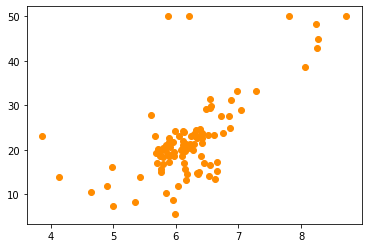

In [26]:
#회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화
#결정 트리의 하이퍼 파라미터인 max_depth의 크기를 변화시키면서 어떻게 회귀 트리 예측선이 변화하는지 살펴봄

#Price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만을 이용해 선형 회귀와 결정 트리 회귀로 PRICE 예측 회귀선을 표현

#RMrhk PRICE 칼럼만을 추출. 2차원 평면상에서 X축에 독립변수인 RM, Y축에 종속변수인 PRICE만을 가지고 더 직관적으로 예측값 시각화


from sklearn.datasets import load_boston

#보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
#boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DF에 추가함.
bostonDF['PRICE'] = boston.target

bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100,random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression

#선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max depth는
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

#실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개의 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

#보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

#학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

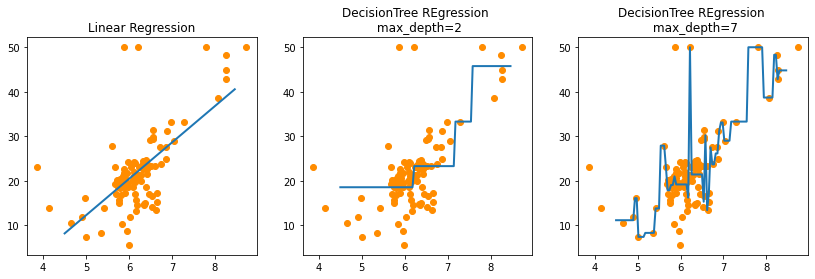

In [31]:
#LinearRegression과 DecisionTreeRegressor의 max_depth를 각각 2, 7로 해서 학습된 Regressor에서 예측한 Price 회귀선을 그려봄

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

#X축 값을 4.5~8.5로 변환하여 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
#선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth=2)

#DecisionTreeRegressor의 max_depth를 2로 했을 때의 회귀 예측선
ax2.set_title('DecisionTree REgression \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

#DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('DecisionTree REgression \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

* 선형 회귀는 직선으로 예측 회귀선으로 표현하는데 반해, 회귀 트리의 경우는 분할되는 데이터 지점에 따라서 브랜치를 만들면서 계단 형태로 회귀선을 만듦
* max_depth = 7인 경우 학습 데이터 셋의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만듦. 과적합이 되기 쉬운 모델이 되었음.

## 09 회귀 실습 - 자전거 대여 수요 예측

### 데이터 클렌징 및 가공

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

#해당 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성되어 있음

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [35]:
#데이터 칼럼을 살펴봄
bike_df.info()

#Null 데이터 없음. 대부분 int 또는 float이지만 datetime만 object. 이에 대한 가공 필요.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [36]:
#문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

#새롭게 year, month, day, hour 칼럼이 추가됨

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [37]:
#casual + registerd = count임. 상관도가 높아 예측을 저해할 수 있어 칼럼 삭제
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [40]:
#다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정
#RMSLE(Root Mean Square Log Error)를 수행하는 성능 평가 함수 직접 만들기

from sklearn.metrics import mean_squared_error, mean_absolute_error

#log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error= (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

#MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    #MSE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

* rmsle() 함수를 만들 때 log()를 사용하면 오버플로나 언더플로 오류가 발생하기 쉬움
* log()보다는 log1p()를 이용하는데, log1p()는 1+log() 값으로 문제를 해결해줌
* log1p()로 변환된 값은 다시 넘파이의 expm1() 함수로 쉽게 원래의 스케일로 복원될 수 있음

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

* 회귀 모델 적용하기 전 결괏값이 정규 분포로 돼 있는지 확인하고 카테고리형 회귀 모델일 경우 원-핫 인코딩으로 피처를 인코딩함
* 회귀 모델을 적용하면서 두 가지 사항을 확인

In [41]:
#사잇킷런의 LinearRegression 객체를 이용해 회귀 예측을 함
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [42]:
#실제 값과 예측값이 어느 정도 차이가 나는지 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    #DF의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']) - result_df['predicted_count']
    
#예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


* 회귀에서 큰 예측 오류가 발생할 경우 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인함
* Target 값의 분포는 정규분포가 가장 좋음

<AxesSubplot:>

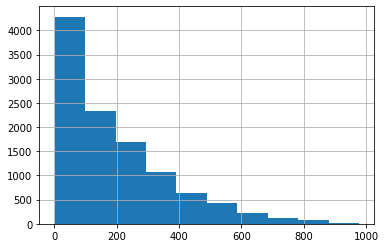

In [43]:
y_target.hist()

* count 칼럼 값이 정규 분포가 아닌 0-200 사이에 왜곡돼 있는 것을 알 수 있음
* 왜곡된 값을 정규분포 형태로 가장 일반적인 방버븡ㄴ 로그를 적용해 변환하는 것
* log1p()를 이용


* 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 expm1() 함수를 적용해 원래 scale 값으로 원상 복구
* log1p()를 적용한 'count'값의 분포 확인

<AxesSubplot:>

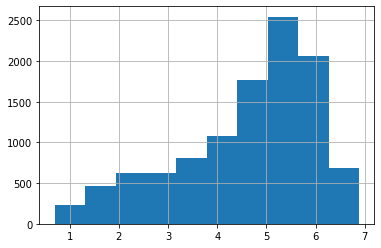

In [45]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

* 로그로 Target값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됨
* 이를 이용해 다시 학습한 후 평가 수행

In [47]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

In [48]:
#테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 exmp1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test) #입력 어레이의 값에 대해 exp(x) - 1

#예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측되었으므로 다시 exmp1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


* RMSLE 오류는 줄어들었지만 RMSE는 오히려 늘어남
* 각 피처의 회귀계수 값을 시각화

<AxesSubplot:>

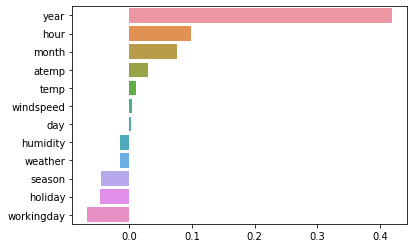

In [49]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [51]:
#year, month, day, hour 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

#사이킷런의 선형회귀모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능을 확인

#원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
#end of function get_model_predict

#모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.1)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

#원핫 인코딩 적용하고나서 선형 회귀의 예측 성능이 많이 향상됨

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 1.227, RMSE: 174.258, MAE: 119.504


<AxesSubplot:>

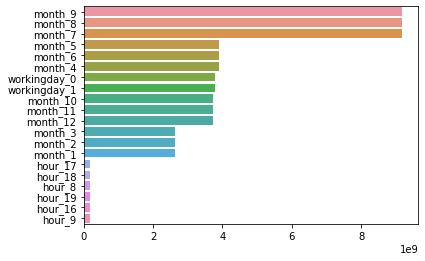

In [52]:
#회귀 계수 높은 피처 다시 시각화
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* 월 관련 피처들과 workingday 관련 피처들, hour 관련 피처들의 회귀 계수가 높은 것을 알 수 있음
* 이처럼 선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 성능에 큰 영향을 미칠 수 있음

* 회귀 트리를 이용해 회귀 예측 수행
* Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가
* XGBoost는 DF이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DF의 values 속성을 이용해 넘파이 ndarray로 변환

In [55]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, XGBoost, LightGBM 모델 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)

xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    #XGBoost의 경우 DF이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.478, MAE: 31.149
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.346, MAE: 32.748
[02:15:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


* 앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됐지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님
* 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있음

## 10 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
* 79개의 변수로 구성된 이 데이터는 미국 아이오와 주의 에임스 지방의 주택 가격 정보를 가지고 있음
* RMSLE(Root Mean Squared Log Error)를 기반으로 성능 펴가
* 가격이 비싼 주택일 수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용

### 데이터 사전 처리(Preprocessing)

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
#데이터 세트의 전체 크기, 칼럼 타입, Null이 있는 칼럼과 그 건수를 내림차순으로 출력
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


* 데이터 세트는 1460개의 레코드와 81개의 피처로 구성
* 피처의 타입은 숫자형은 물론 문자형도 많이 있음

    Target을 제외한 80개의 피처 중 43개가 문자형이며 나머지가 숫자형

* 데이터 양에 비해 Null값이 많은 피처도 있음

    * 전체 1480개 데이터 중 PoolQC, MiscFeature, Alley, Fence는 1000개가 넘는 데이터가 Null
    * Null값이 너무 많은 피처는 드롭

회귀 모델 적용 전 타깃값의 분포도가 정규 분포인지 확인

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

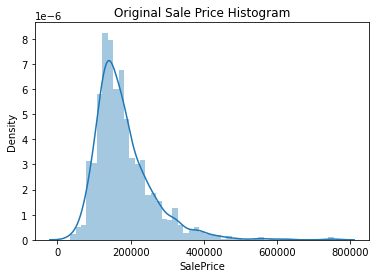

In [6]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

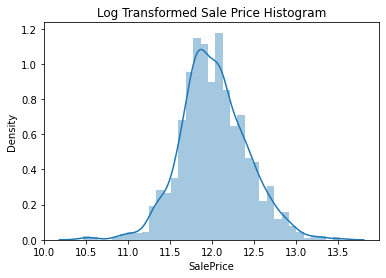

In [7]:
#정규 분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환 적용
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [8]:
#SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
#드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

In [9]:
#Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


* 이제 문자형 피처 제외하고는 Null값이 없음. 문자형 피처는 모두 원핫 인코딩으로 변환
* 판다스의 get_dummies()는 문자열 피처를 원핫 인코딩 변환하면서 Null값은 None 칼럼으로 대체해줌

In [10]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


### 선형 회귀 모델 학습/예측/평가

* 예측 평가는 RMSLE 이용
* 그런데 타깃 값이 SalesPrice가 로그 변환됭어 예측값도 원본 SalePrice 예측값의 로그 변환 값
* 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동적으로 측정됨

In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [14]:
#선형회귀 모델 학습 예측 평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154308, 0.12750846334053026, 0.17628250556471395]

* 라쏘 회귀의 경우 회귀 성능이 많이 떨어저 하이퍼 파라미터 튜닝 필요
* alpha 파라미터 최적화를 릿지와 라쏘 모델에 대해서 수행

* 먼저 피처벌 회귀 계쑤 시각화해서 모델별로 어떠한 피처의 회귀 계쑤로 구성되는지 확인

In [16]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

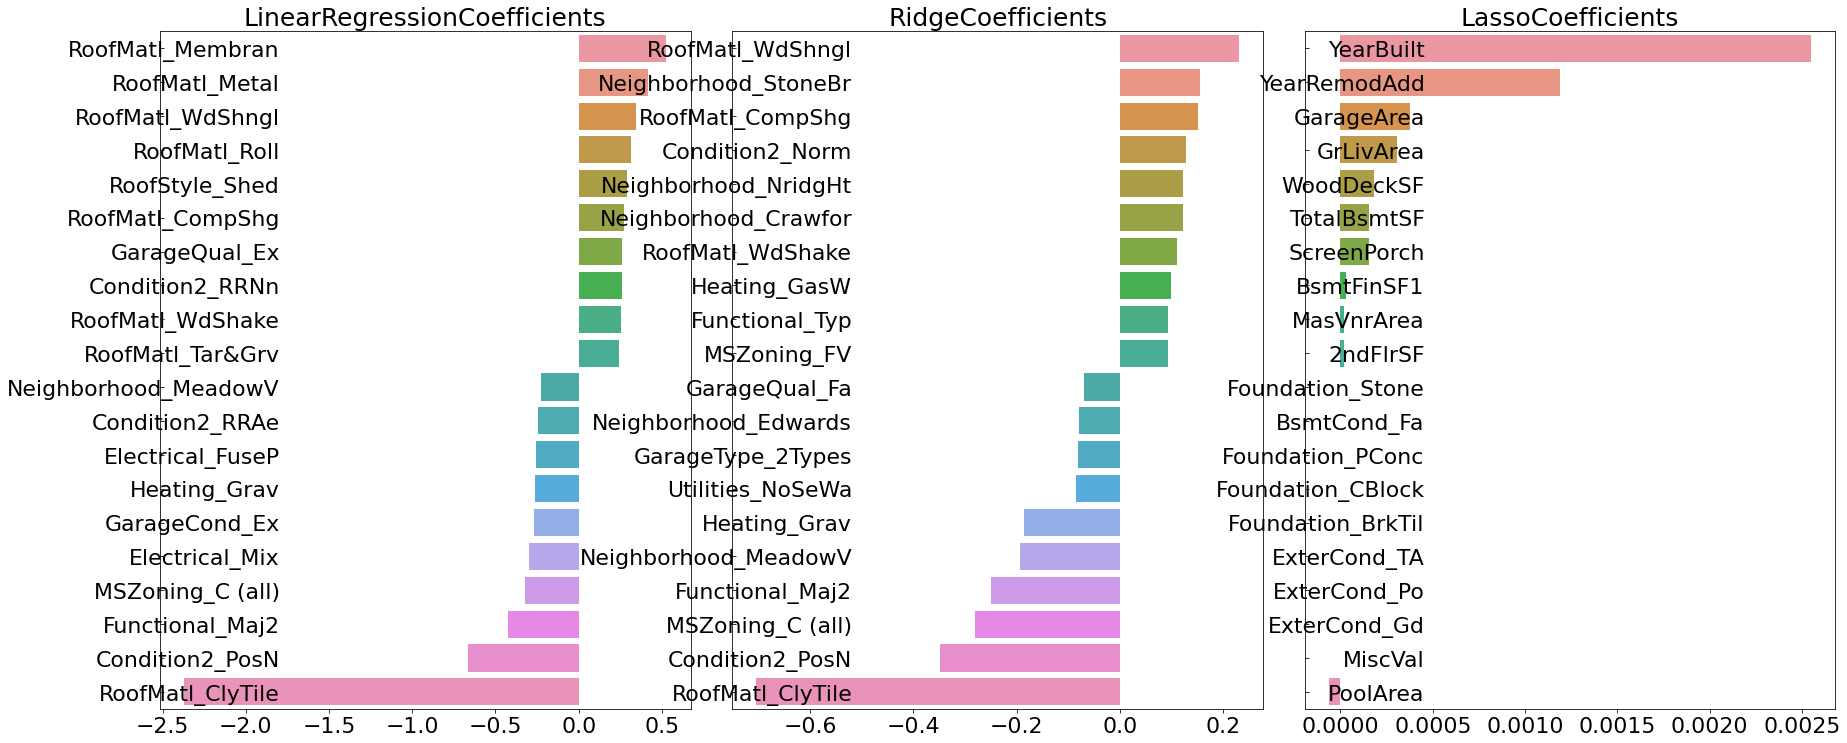

In [19]:
def visualize_coefficient(models):
    #3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    #입력 인자로 받은 list객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        #상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        #ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+ 'Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
#앞 예제에서 학습한 lr_reg, ridge_Reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

* 모델별 회귀 계수 보면 OLS 기반 LinearRegression과 Ridge는 회귀 계수가 유사한 형태
* 라쏘는 전체적으로 회귀 계수 값이 매우 작음
* 학습과 테스트 데이터 세트를 분할하지 않고 전체 데이터 세트를 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE 측정

In [21]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        #분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
#앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [22]:
#여전히 라쏘가 OLS나 릿지보다 성능이 떨어짐
#릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키면서 최적 값 도출

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


* 릿지 모델의 경우 alpha가 12에서 최적 평균 RMSE가 0.148, 라쏘 모델의 경우 alpha가 0.001에서 최적 평균 RMSE가 0.142임
* 라쏘는 alpha 값 최적화 이후 예측 성능이 ㅁ낳이 좋아짐

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


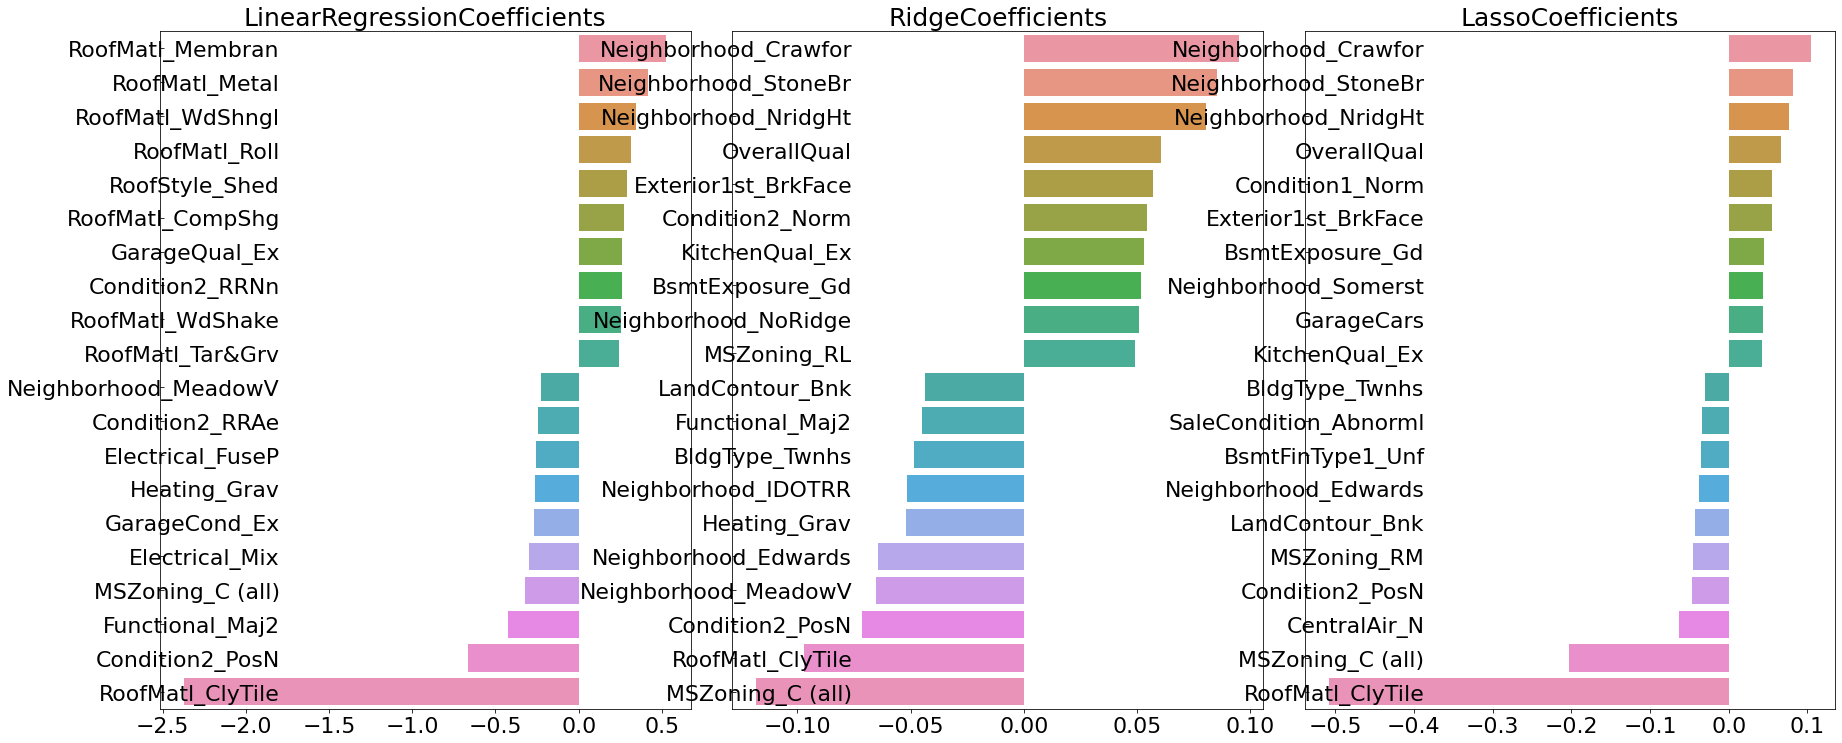

In [25]:
#앞의 최적화 alpha값으로 학습 데이터를 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

#모든 모델의 회귀 계쑤 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

* alpha값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아짐
* 모델별 회귀 계수도 많이 달라짐
* 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많으 차이가 있었지만, 이번에느 ㄴ릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음
* 다만 라쏘 모델에서는 릿지에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작음


* 추가적으로 데이터셋을 가공하여 모델 튜닝을 더 진행
* 피처 데이터 세트의 데이터 분포도와 이상치 데이터 처리

In [27]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
#house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
#skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [28]:
#추출된 왜곡 정도나 높은 피처를 로그 변환
house_df[skew_featues_top.index] = np.log1p(house_df[skew_features_top.index])

In [31]:
#왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

#피처를 로그로 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


* 회귀 계수 시각화 결과를 보면 세 모둘 모두 GrLivArea, 즉 주거 공간의 크기가 회귀 계수가 가장 높은 피처가 됐음
* 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상신선에서의 결과가 이제야 도출됨

* 이상치 데이터 분석
* 중요 피러의 이상치 데이터의 처리가 매우 중요

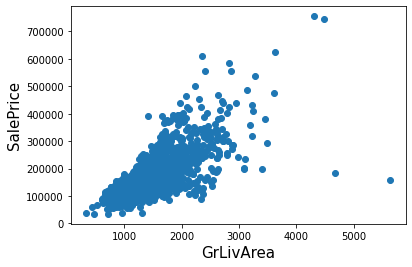

In [33]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [35]:
#일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GirLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있음
# 하지만 위 그림에서 관계에서 너무 어긋나있는 데이터들은 모두 이상치로 간주하고 삭제함

#데이터 변환이 완ㄹ된 house_df_ohe에서 대상 데이터 필터링
#모두 로그 변환됐으므로 이를 반영한 조건을 생성한 뒤 불린 인덱싱으로 대상을 찾음
#찾은 데이터의 DF 인덱스와 drop()을 이용해 해당 데이터 삭제

#GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

#DF의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [40]:
#업데이트된 house_df_ohe 기반으로 피처 데이터셋과 타깃 데이터셋 다시 생성하고 앞에서 정의한 print_best_params() 함수 이용해 릿지와 라쏘 모델의 최적화 수행
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


* 단 두 개의 이상치 데이터 제거로 예측 수치가 매우 크게 향상
* 릿지 모델의 경우 최적 alpha 값은 12에서 8로 변함
* 평균 RMSE가 0.1275에서 0.1125로 개선
* 라쏘 모델의 경우는 평규 RMSE가 0.1252에서 0.1122로 개선됨

### 회귀 트리 모델 학습/예측/평가

* XGBoost는 XGBRegressor 클래스를, LightGBM은 LGBMRegressor 클래스를 이용
* XGBoost, LightGBM 모두 수행 시간이 오래 걸릴 수 있느 ㄴ관계로 다음과 같은 하이퍼 파라미터 설정을 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE값 구하기

In [41]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[20:43:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.115, 최적 alpha:{'n_estimators': 1000}


In [43]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, 
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(xgb_reg, xgb_params)

[20:45:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.115, 최적 alpha:{'n_estimators': 1000}


### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

* 개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값을 예측
* 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합

In [47]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [48]:
#개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

#개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred, 'Ridge': ridge_pred, 'Lasso': lasso_pred}

#최종 혼합 모델, 개별 모델의 RMSE값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470514
Ridge 모델의 RMSE: 0.10345177546603257
Lasso 모델의 RMSE: 0.10024170460890039


In [52]:
#XGBoost와 LightGBM을 혼합
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred, 'XGBM': xgb_pred, 'LGBM': lgbm_pred}

get_rmse_pred(preds)

[20:54:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.0999551123128891
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.10382510019327311


### 스태킹 앙상블 모델을 통한 회귀 예측

* 4장 분류에서 소개한 스태킹 모델은 회귀에도 적용 가능
* 스태킹 모델은 두 종류의 모델이 필요함(개별적인 기발 모델과 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델)
* 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것


* 최종 메타 모델이 학습할 피처 데이터셋은 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것
* 개별 모델을 스태킹 모델로 제공하기 위해 데이터 세트를 생성하기 위한 get_stacking_base_datasets() 함수

In [63]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    #지정된 n_folds값으로 KFolds 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

        # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
        test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    #test_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테드스 데이터
    return train_fold_pred, test_pred_mean

In [69]:
# get_stacking_base_Datasets()는 넘파이 ndarray를 인자로 사용하므로 DF을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

#각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
[21:40:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1 시작
[21:40:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2 시작
[21:40:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3 시작
[21:40:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4 시작
[21:40:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작


In [72]:
#각 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 겨랍해 최종 메타 모델에 적용
#메타 모델은 별도의 라쏘 모델을 이용하며, 최종적으로 예측 및 RMSE를 측정

#개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

#최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.0005)

#개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09738961783055043


최종적으로 스태킹 회귀 모델을 적용할 결과, 테스트 데이터 세트에서 RMSE가 약 0.0972로 가장 좋은 성능 평가를 보여줌
스태킹 모델은 분류 뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델

### 11. 정리

* 머신러닝 기반 회귀
* 선형 회귀: 실제값과 예측값의 차이인 오류를 최소로 줄일 수 있는 선형 함수를 찾아 선형 함수에 독립 변수(피처)를 입력해 종속변수(타깃값, 예측값)을 예측
* 최적의 선형 함수를 찾기 위해 회귀 계수 W를 변수로 하는 비용 함수로 만들고 이 비용 함수가 최소화되는 W의 값을 찾아 선형 함수를 도출
* 비용 함수 최소화하는 방법으로 **경사하강법**


* 실제값과 예측값의 차이를 최소화하는 것에만 초점을 맞추면 학습 데이터에 과적합될 수 있음
* 해결 위해 **규제(Regularization)**를 선형 회귀에 도입
    * L2 규제를 적용한 릿지, L1 규제를 적용한 라쏘, L1에 L2를 결합한 엘라스틱넷


* **로지스틱 회귀**: 선형 회귀에 분류 적용. 이름은 회귀지만 실제로는 분류 알고리즘
* 선형 함수 대신 최적의 시그모이드 함수를 도출하고, 독립변수를 이 시그모이드 함수에 입력해 반환된 결과를 확률값으로 변환해 예측 레이블을 결정
* 성능 매우 뛰어난 분류 알고리즘. 특히 이진 분류나 희소 행렬로 표현되는 텍스트 기반의 분류에서 높은 예측 성능


* **회귀 트리**를 이용해 예측
* 분류를 위한 분류 트리와 크게 다르지 않지만 리프 노드에서 예측 결정 값을 만드는 과정에 차이가 있음
* 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산함
* 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 모두 회귀 트리를 이용해 회귀 수행


* 선형회귀는 **데이터 값의 분포도와 인코딩 방법**에 많은 영향을 받음
* 데이터값이 정규 분포 선호. 타깃값의 분포도가 왜곡되지 않아야 함
* If 왜곡 -> 로그 변환
* 선형 회귀는 데이터 세트에 카테고리형 데이터가 있을 경우 웟핫 인코딩 변환. 회귀는 크게 영향 받지 않음